In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/alexander/miniconda3/envs/2_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Полиномиальная регрессия и оверфиттинг

In [2]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

## Обучаем модель с регуляризацией
@ignore_warnings(category=ConvergenceWarning)
def train_model(xs, ys, alpha=0, use_lasso=False):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

[ 1.3989608   0.01849686 -0.45424553]
[  3.33359884  -7.01004959  -6.53241695  28.35401502  -7.63958914
 -26.94082629  17.78395239   4.12156045  -5.94100408   1.26763531]


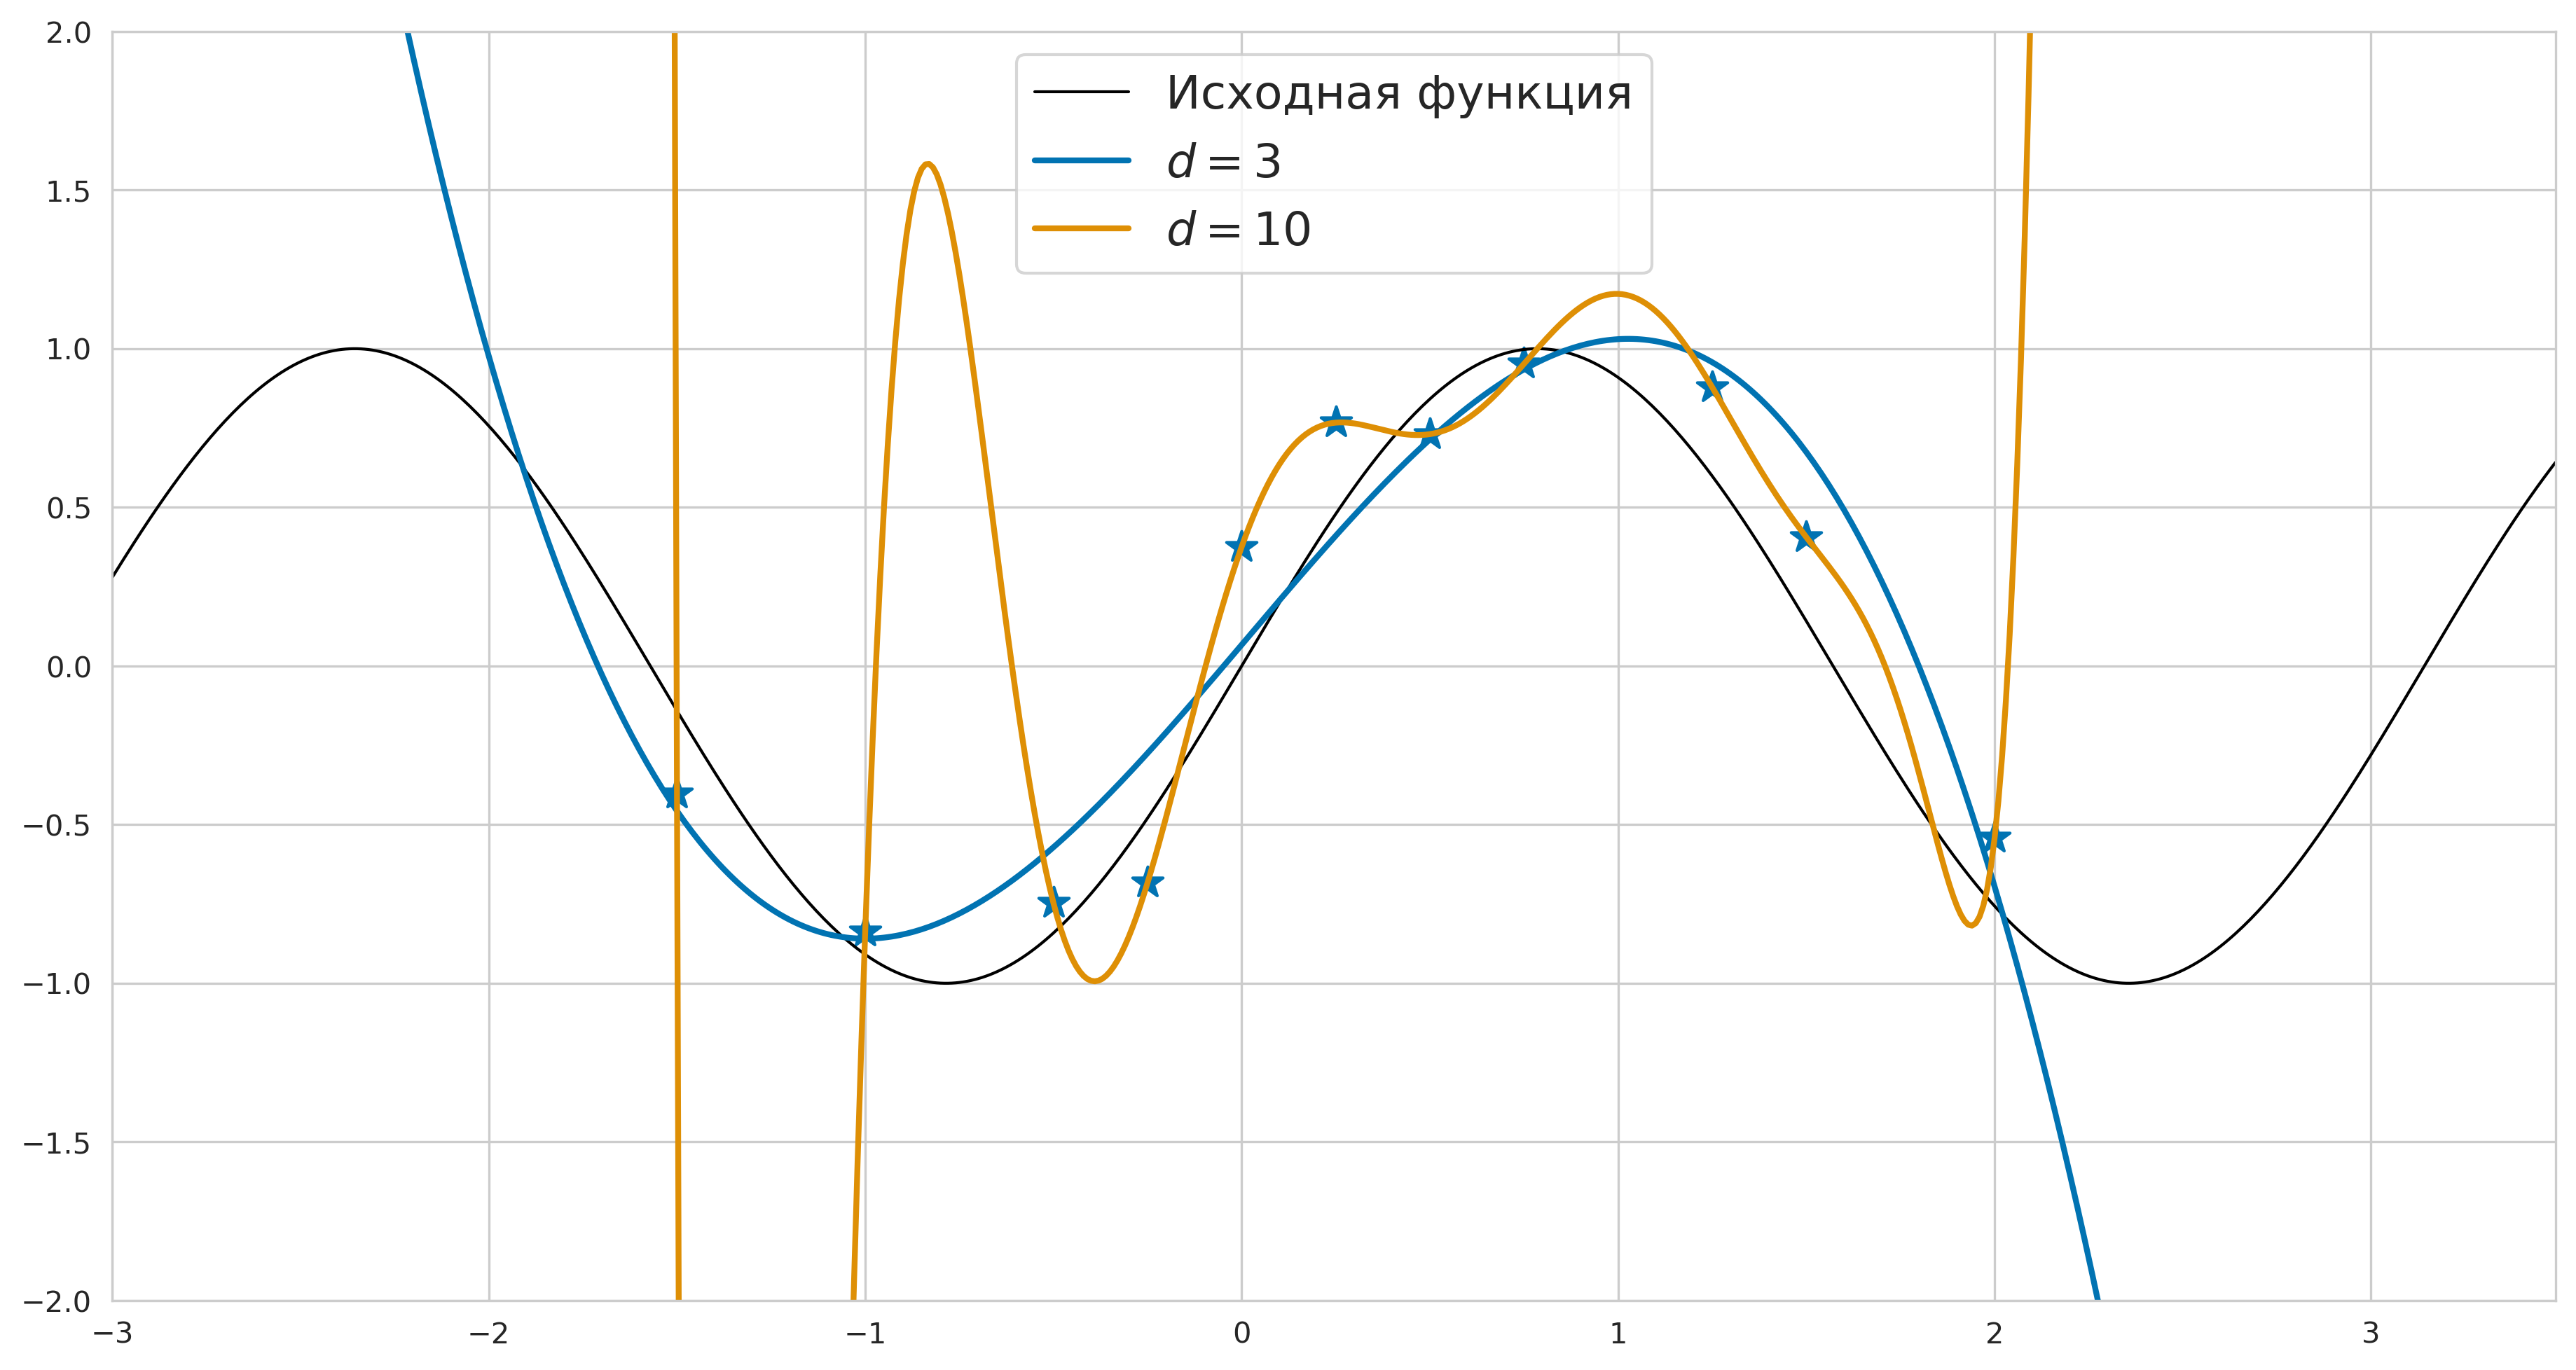

In [3]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 3, 10 ]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = train_model( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

In [4]:
models = [ train_model( xd_d[:, :d], data ) for d in range(1, 11) ]


In [5]:
def logL(model, xs, ys):
    yfit = model.predict(xs)
    return np.sum([ sp.stats.norm.logpdf(ys[i], loc=yfit[i], scale=.25) for i in range(ys.shape[0]) ])

logLs = [logL(models[d-1], xd_d[:,:d], data) for d in range(1, 11)]

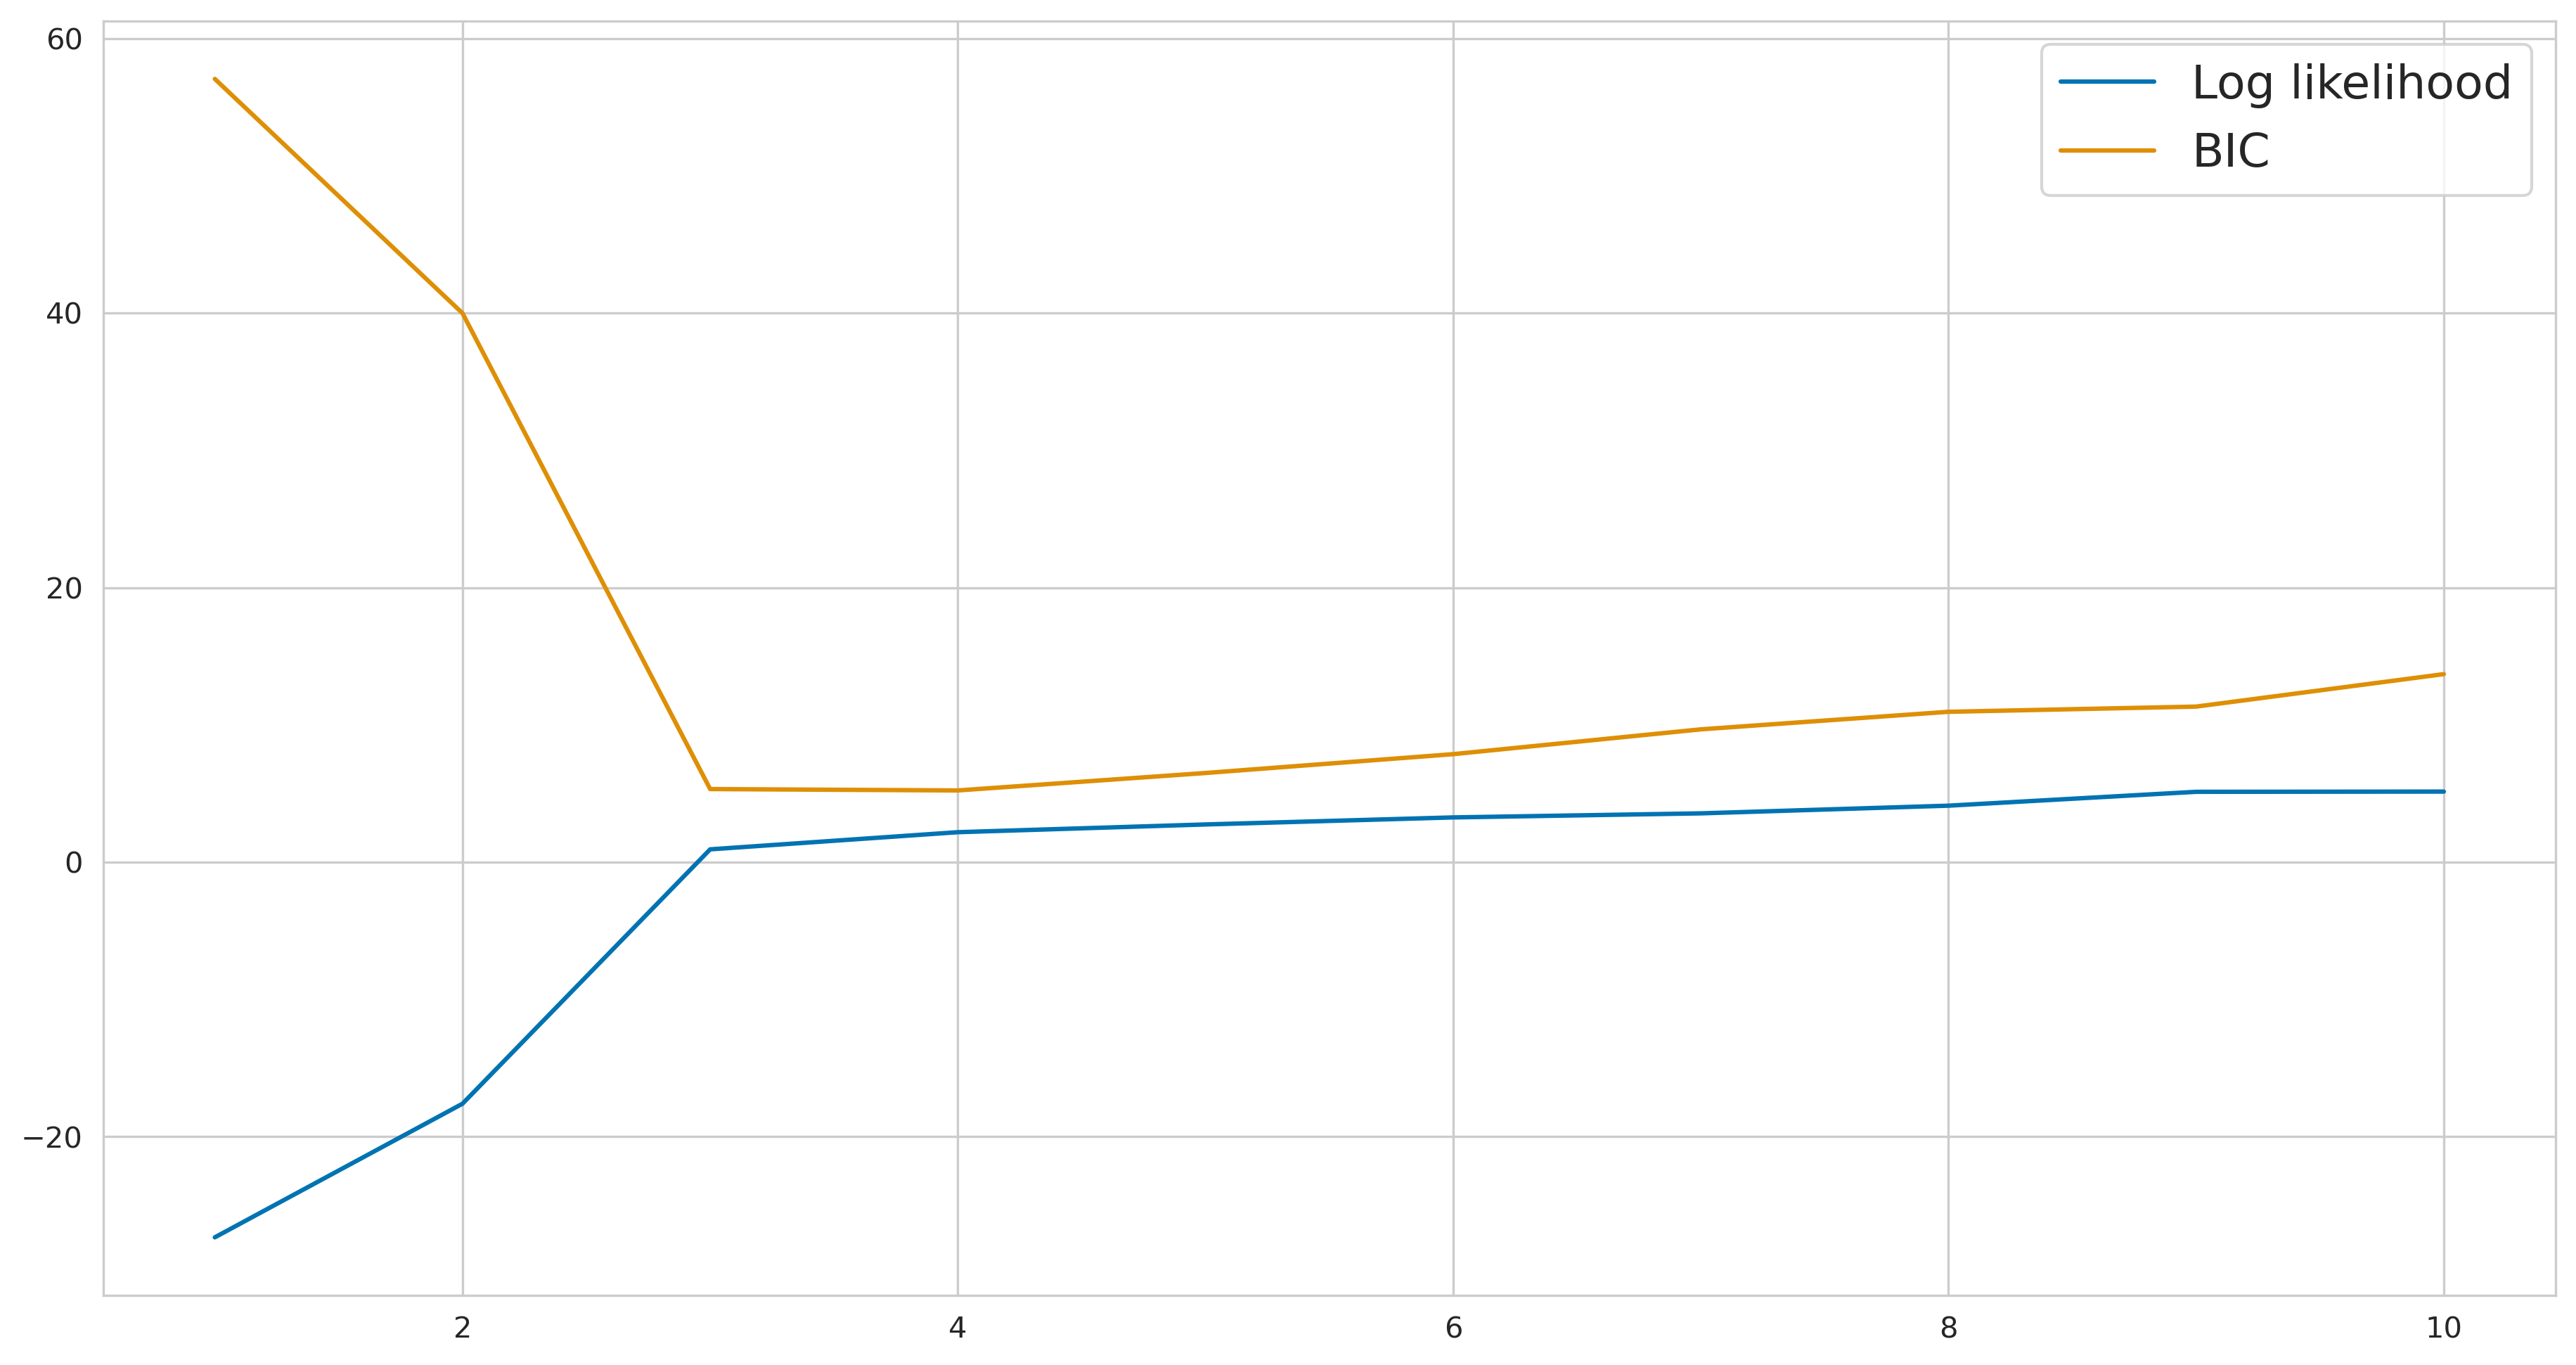

In [6]:
def BIC(ll, N, k):
    return -2*ll + np.log(N)*k

bics = [BIC(logLs[d-1], data.shape[0], d) for d in range(1, 11)]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-2, 2))
ax.plot(range(1, 11), logLs, label="Log likelihood")
ax.plot(range(1, 11), bics, label="BIC")
ax.legend(fontsize=legend_fontsize)
plt.show()

## Статистическая теория принятия решений

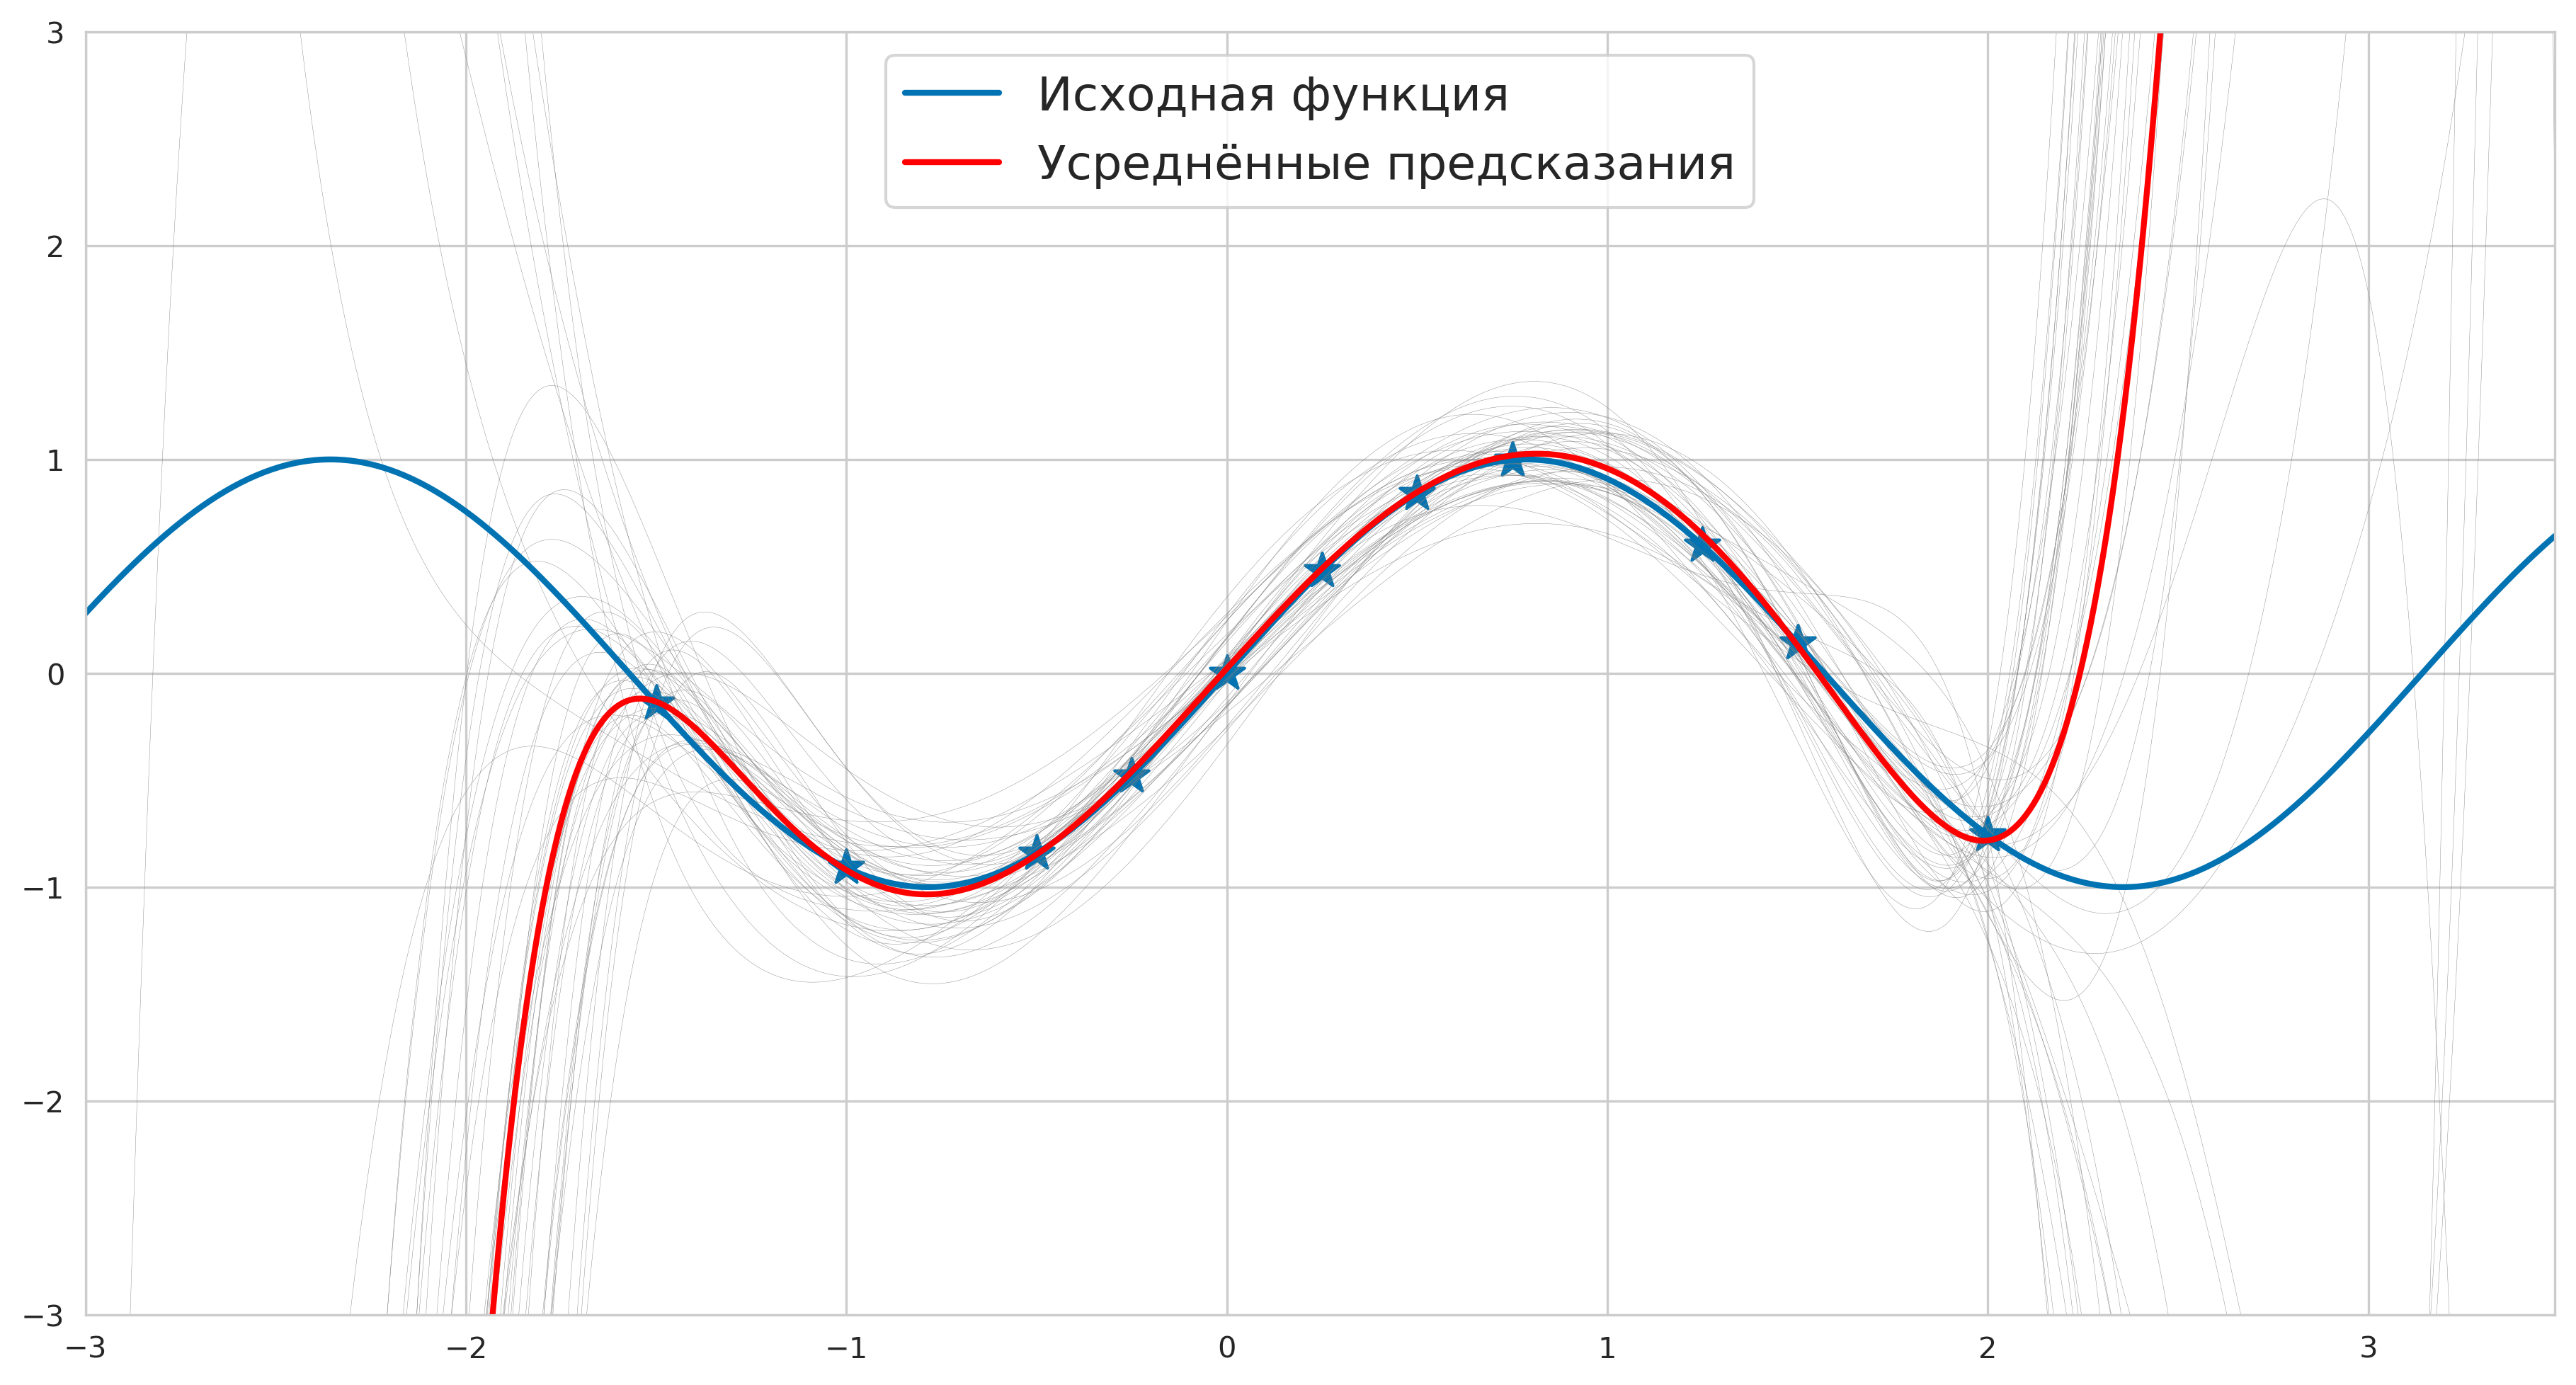

In [7]:
N = 50
alpha = 0.00001
use_lasso = True

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-3, 3))

res = []
for _ in range(N):
    cur_data = orig(xd) + np.random.normal(0, .25, num_points)
    cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
    res.append(cur_model.predict( xs_d ))
    ax.plot(xs, res[-1], linewidth=.1, color="0.5")

ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(xd, orig(xd), marker='*', s=150, color=palette[0])

ax.plot(xs, np.mean( res, axis=0 ), linewidth=2, label="Усреднённые предсказания", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )

(50, 11)


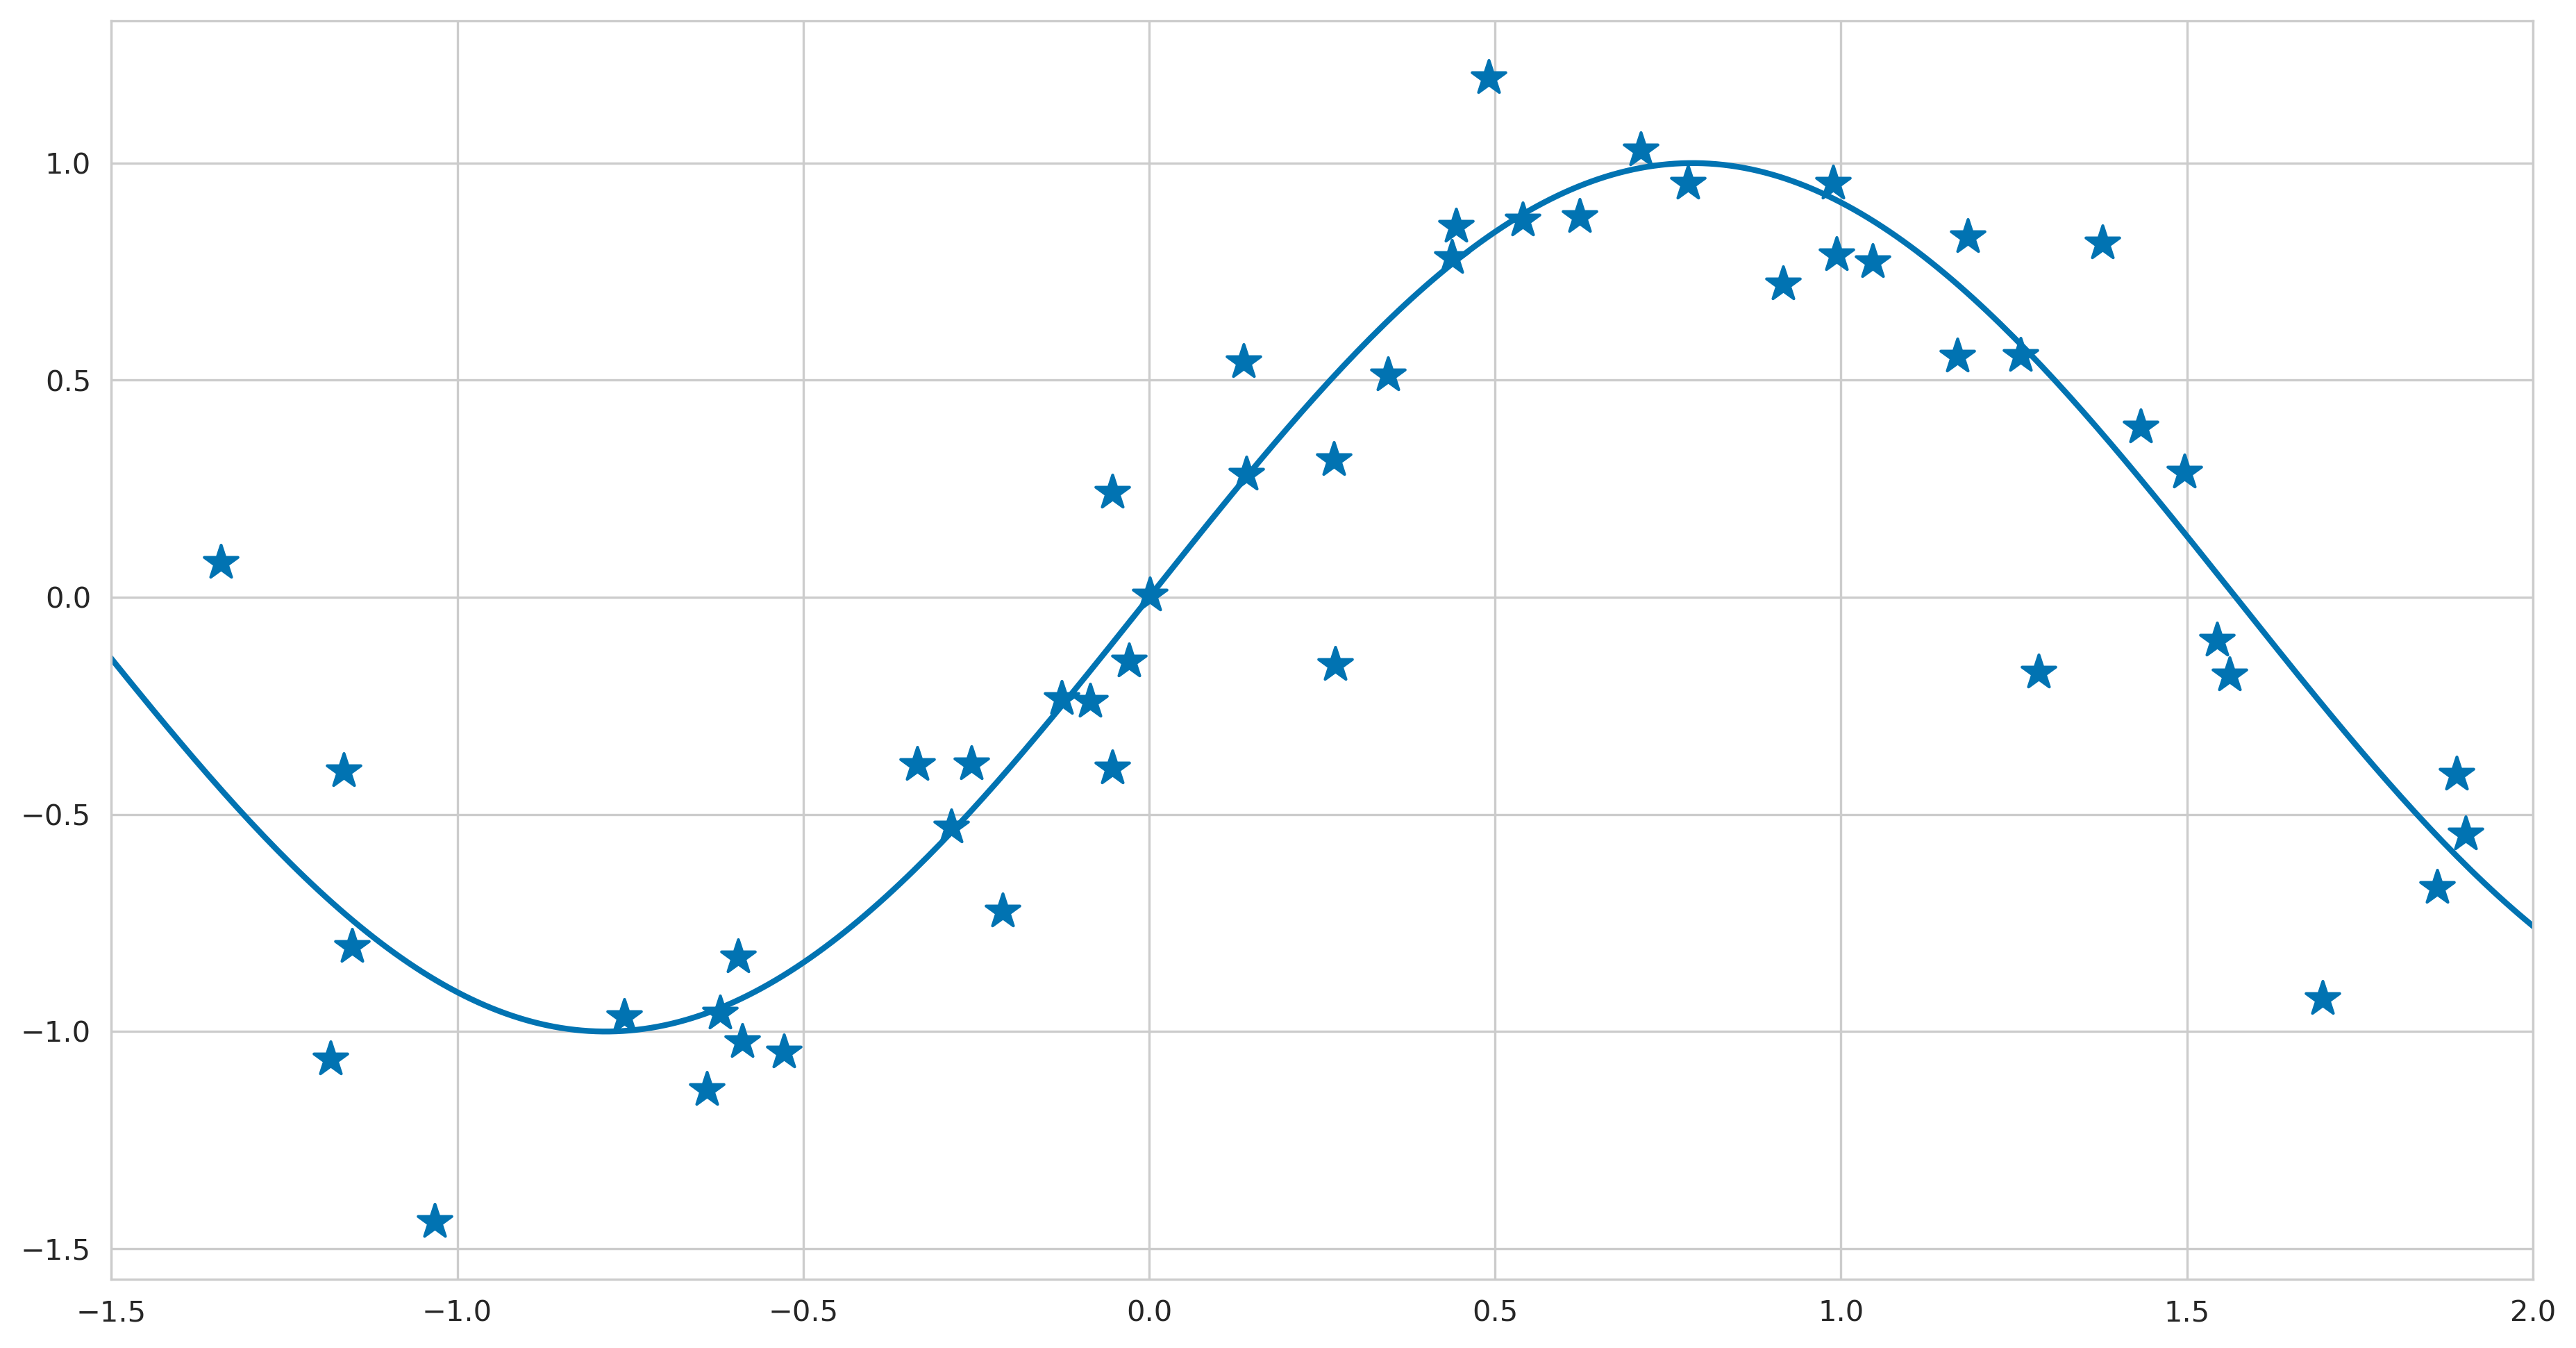

In [8]:
test_set_size = 50
test_set_x = np.random.rand(test_set_size) * (2 + 1.5) - 1.5
test_set_xs = np.vstack([test_set_x ** i for i in range(1, 12)]).transpose()
print(test_set_xs.shape)
test_set_y = orig(test_set_xs[:,0]) + np.random.normal(0, .25, test_set_size)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(test_set_xs[:,0], test_set_y, marker='*', s=150, color=palette[0])
ax.set_xlim((-1.5, 2))

def test_set_error(model, d):
    return np.mean( (test_set_y - model.predict(test_set_xs[:, :d])) ** 2 )

In [9]:
N = 5000
use_lasso=False
alphas = np.logspace(-4, 2, num=20)
errors, biases, variances = [], [], []
for alpha in alphas:
    res, res_preds, res_test = [], [], []
    for _ in range(N):
        cur_data = orig(xd) + np.random.normal(0, .25, num_points)
        cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
        res.append(test_set_error(cur_model, xd_d.shape[1]))
        res_test.append(cur_model.predict(test_set_xs))
        res_preds.append(cur_model.predict( xs_d ))
    res_test = np.array(res_test)
    avg_preds = np.mean(res_test, axis=0)
    errors.append(np.mean(res))
    biases.append(np.mean((avg_preds-orig(test_set_x))**2))
    variances.append(np.mean((res_test-avg_preds)**2))
    print("alpha = %.6f\tmean error = %.6f\tbias = %.6f\tvariance = %.6f" % (alpha, errors[-1], biases[-1], variances[-1]))

alpha = 0.000100	mean error = 13.689277	bias = 0.005162	variance = 13.618705
alpha = 0.000207	mean error = 9.352517	bias = 0.005926	variance = 9.282398
alpha = 0.000428	mean error = 5.394893	bias = 0.022427	variance = 5.315135
alpha = 0.000886	mean error = 2.937612	bias = 0.009770	variance = 2.866778
alpha = 0.001833	mean error = 1.598631	bias = 0.011935	variance = 1.528055
alpha = 0.003793	mean error = 1.047980	bias = 0.012766	variance = 0.976278
alpha = 0.007848	mean error = 0.739607	bias = 0.018674	variance = 0.661400
alpha = 0.016238	mean error = 0.582953	bias = 0.034231	variance = 0.485999
alpha = 0.033598	mean error = 0.472371	bias = 0.041190	variance = 0.364756
alpha = 0.069519	mean error = 0.394498	bias = 0.045271	variance = 0.278829
alpha = 0.143845	mean error = 0.320876	bias = 0.038739	variance = 0.208644
alpha = 0.297635	mean error = 0.264439	bias = 0.028311	variance = 0.163468
alpha = 0.615848	mean error = 0.261173	bias = 0.060654	variance = 0.129029
alpha = 1.274275	mean e

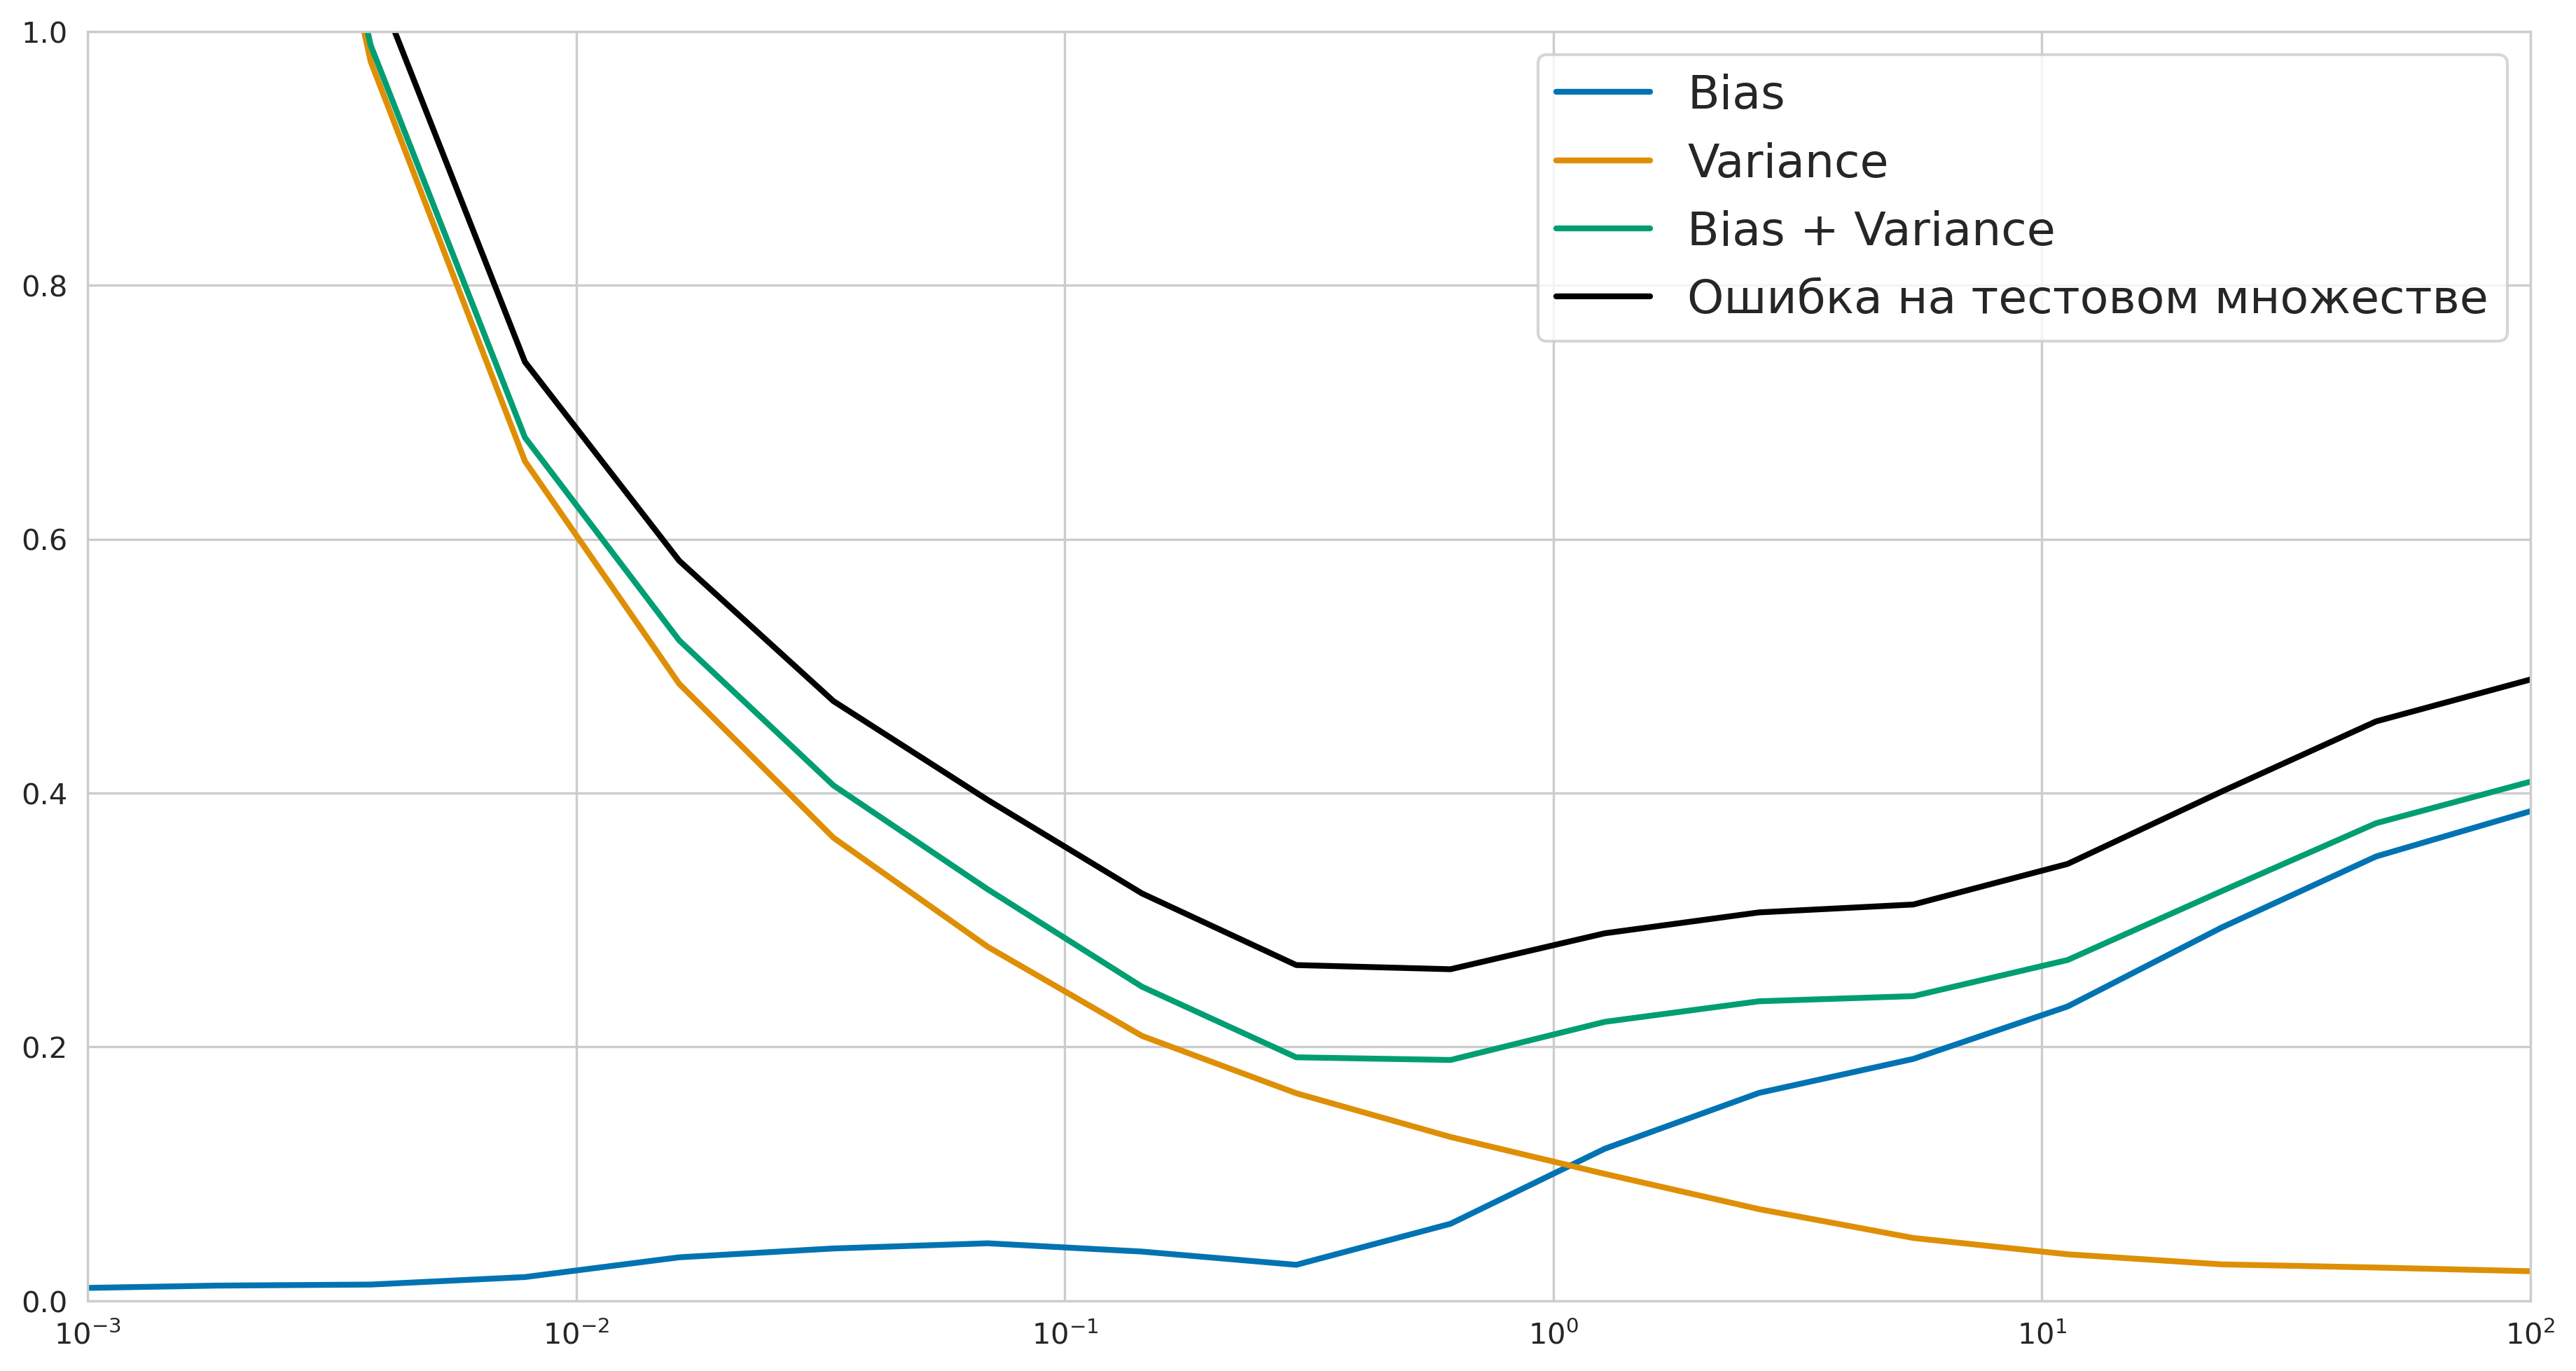

In [10]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
# plt.yscale('log')
plt.xscale('log')
ax.plot(alphas, biases, linewidth=2, label="Bias")
ax.plot(alphas, variances, linewidth=2, label="Variance")
ax.plot(alphas, np.array(biases) + np.array(variances), linewidth=2, label="Bias + Variance")
ax.plot(alphas, errors, linewidth=2, label="Ошибка на тестовом множестве", color="black")
ax.set_ylim((0, 1))
ax.set_xlim((0.001, 100))
ax.legend(fontsize=legend_fontsize)
# fig.savefig('statdecision1.pdf', bbox_inches='tight')

## Эквивалентное ядро в линейной регрессии

[-0.40176311 -0.83633013 -0.7469668  -0.68294038  0.37587604  0.7669255
  0.73072068  0.95244694  0.87819434  0.40564678 -0.54211209]
[-0.40176311 -0.83633013 -0.7469668  -0.68294038  0.37587604  0.7669255
  0.73072068  0.          0.87819434  0.40564678 -0.54211209]
[0.1972983]


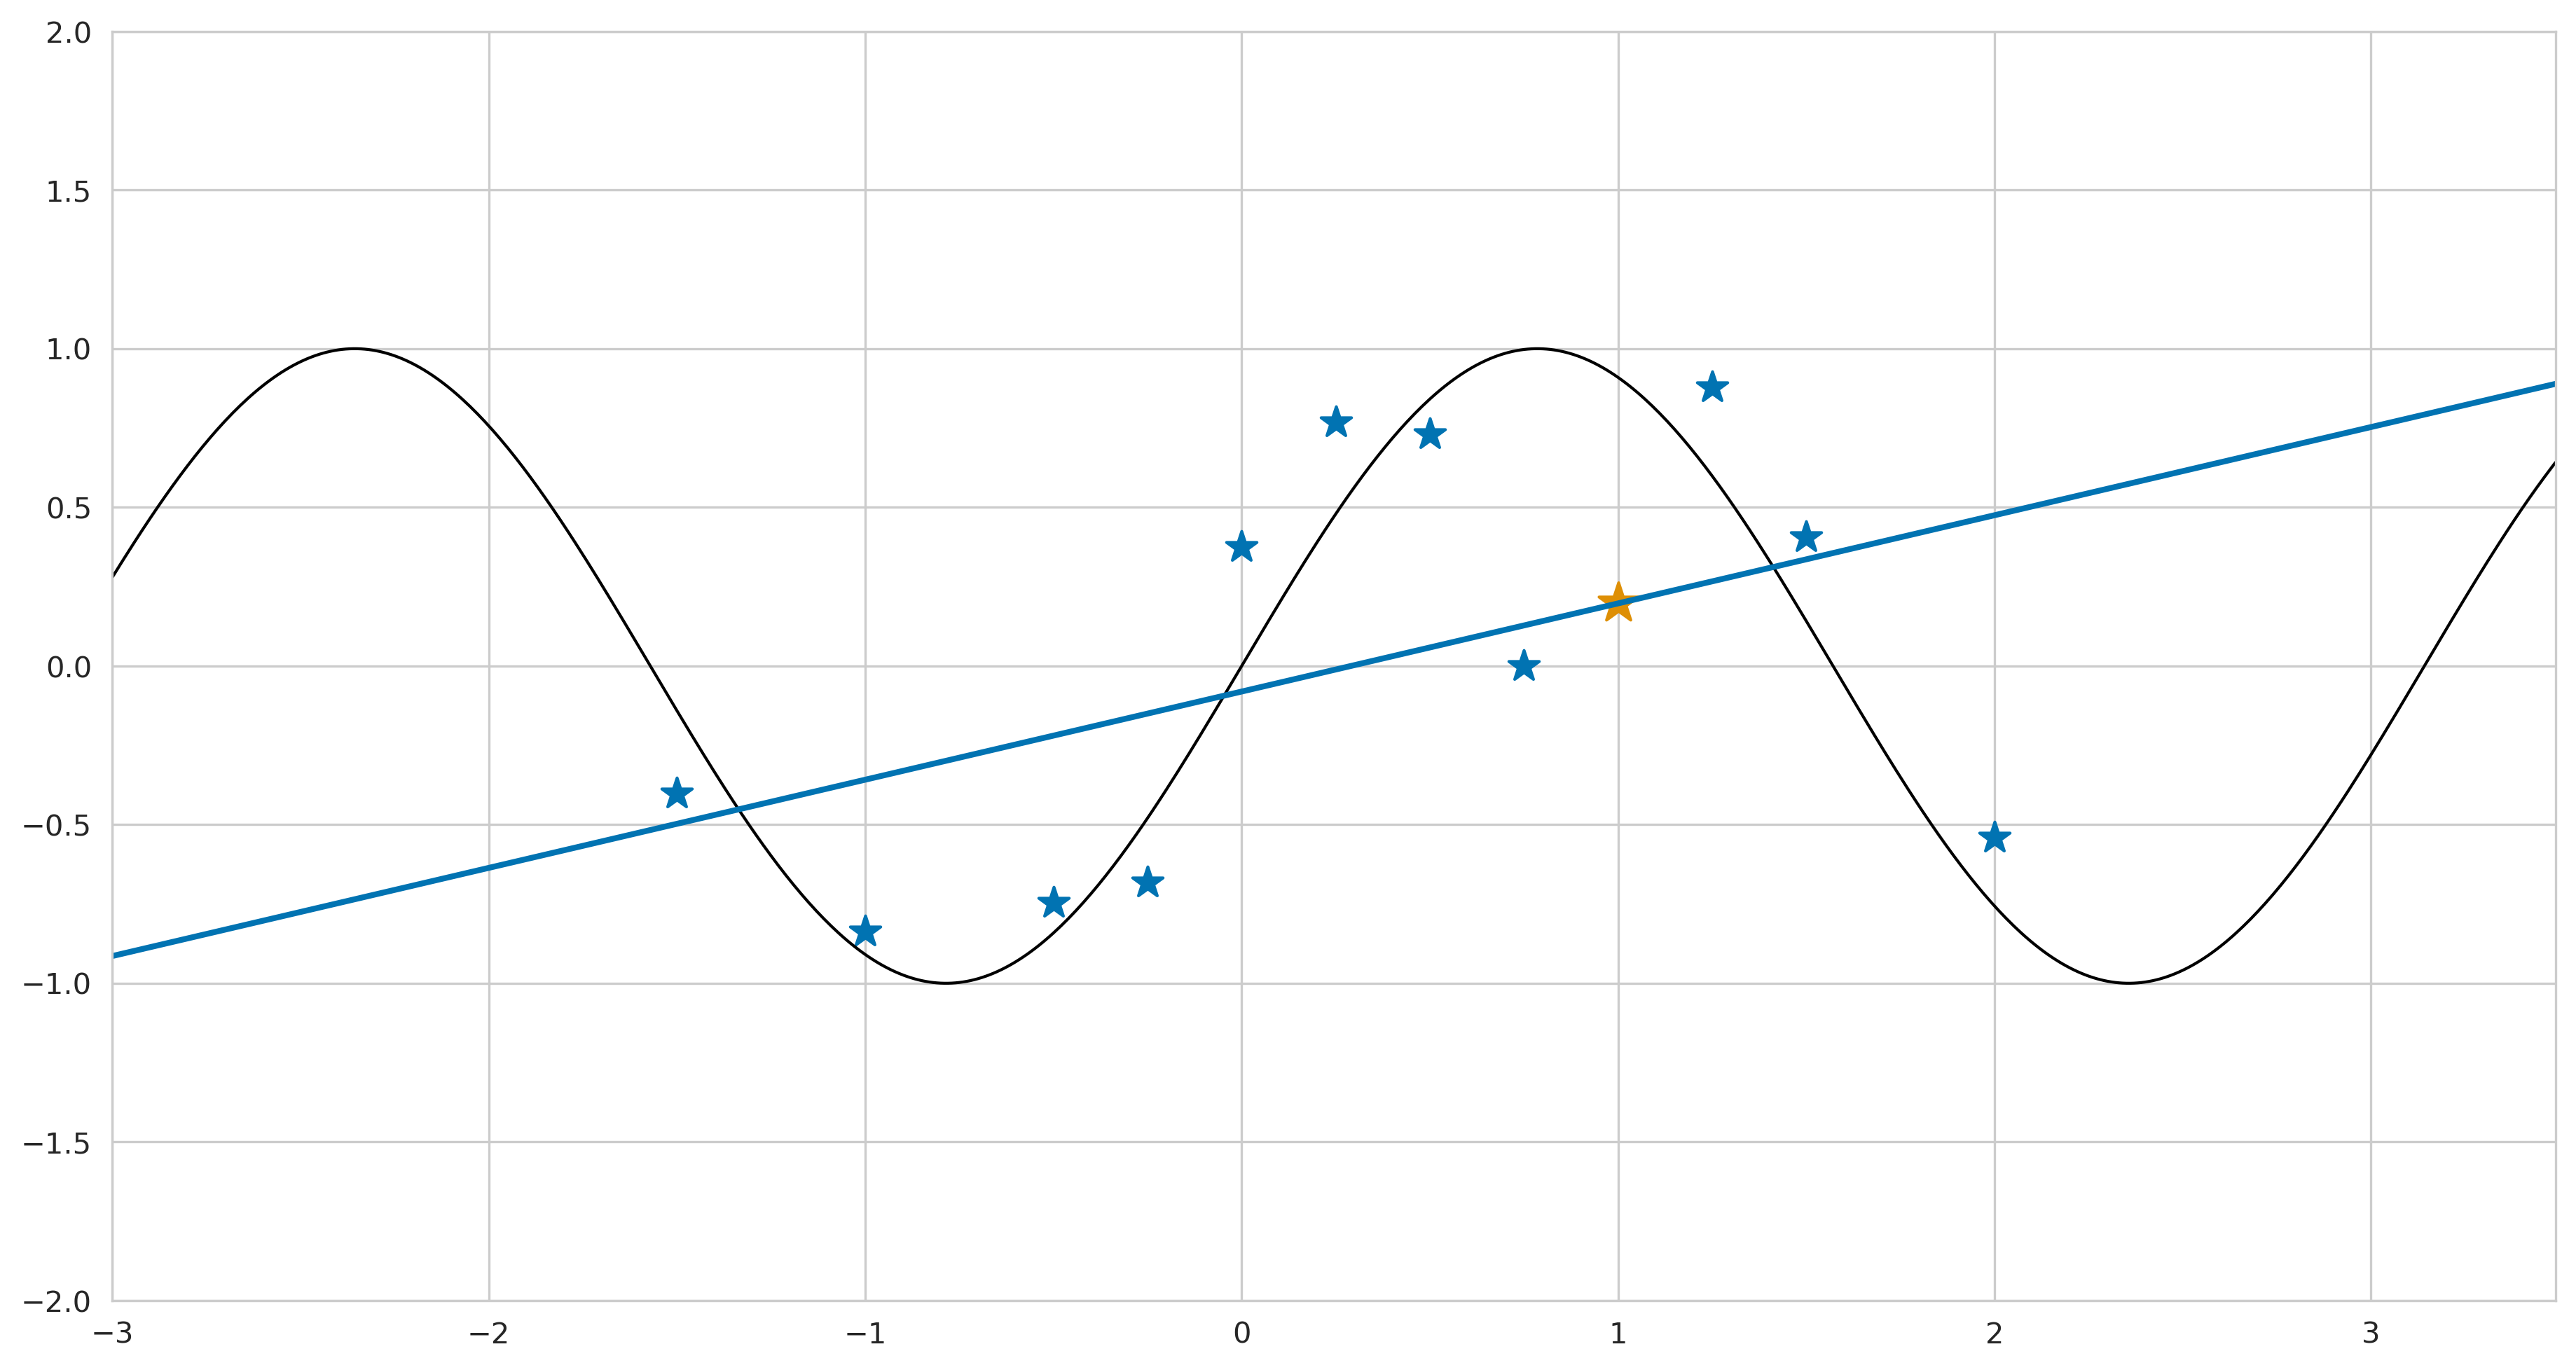

In [11]:
d = 1
x_pred = 1

new_data = np.copy(data)
new_data[7] = 0
cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], new_data )

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, new_data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")
ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)
y_pred = cur_model.predict(np.array([x_pred]).reshape(1,-1))
ax.scatter(x_pred, y_pred, marker='*', s=200)


print(data)
print(new_data)
print(y_pred)

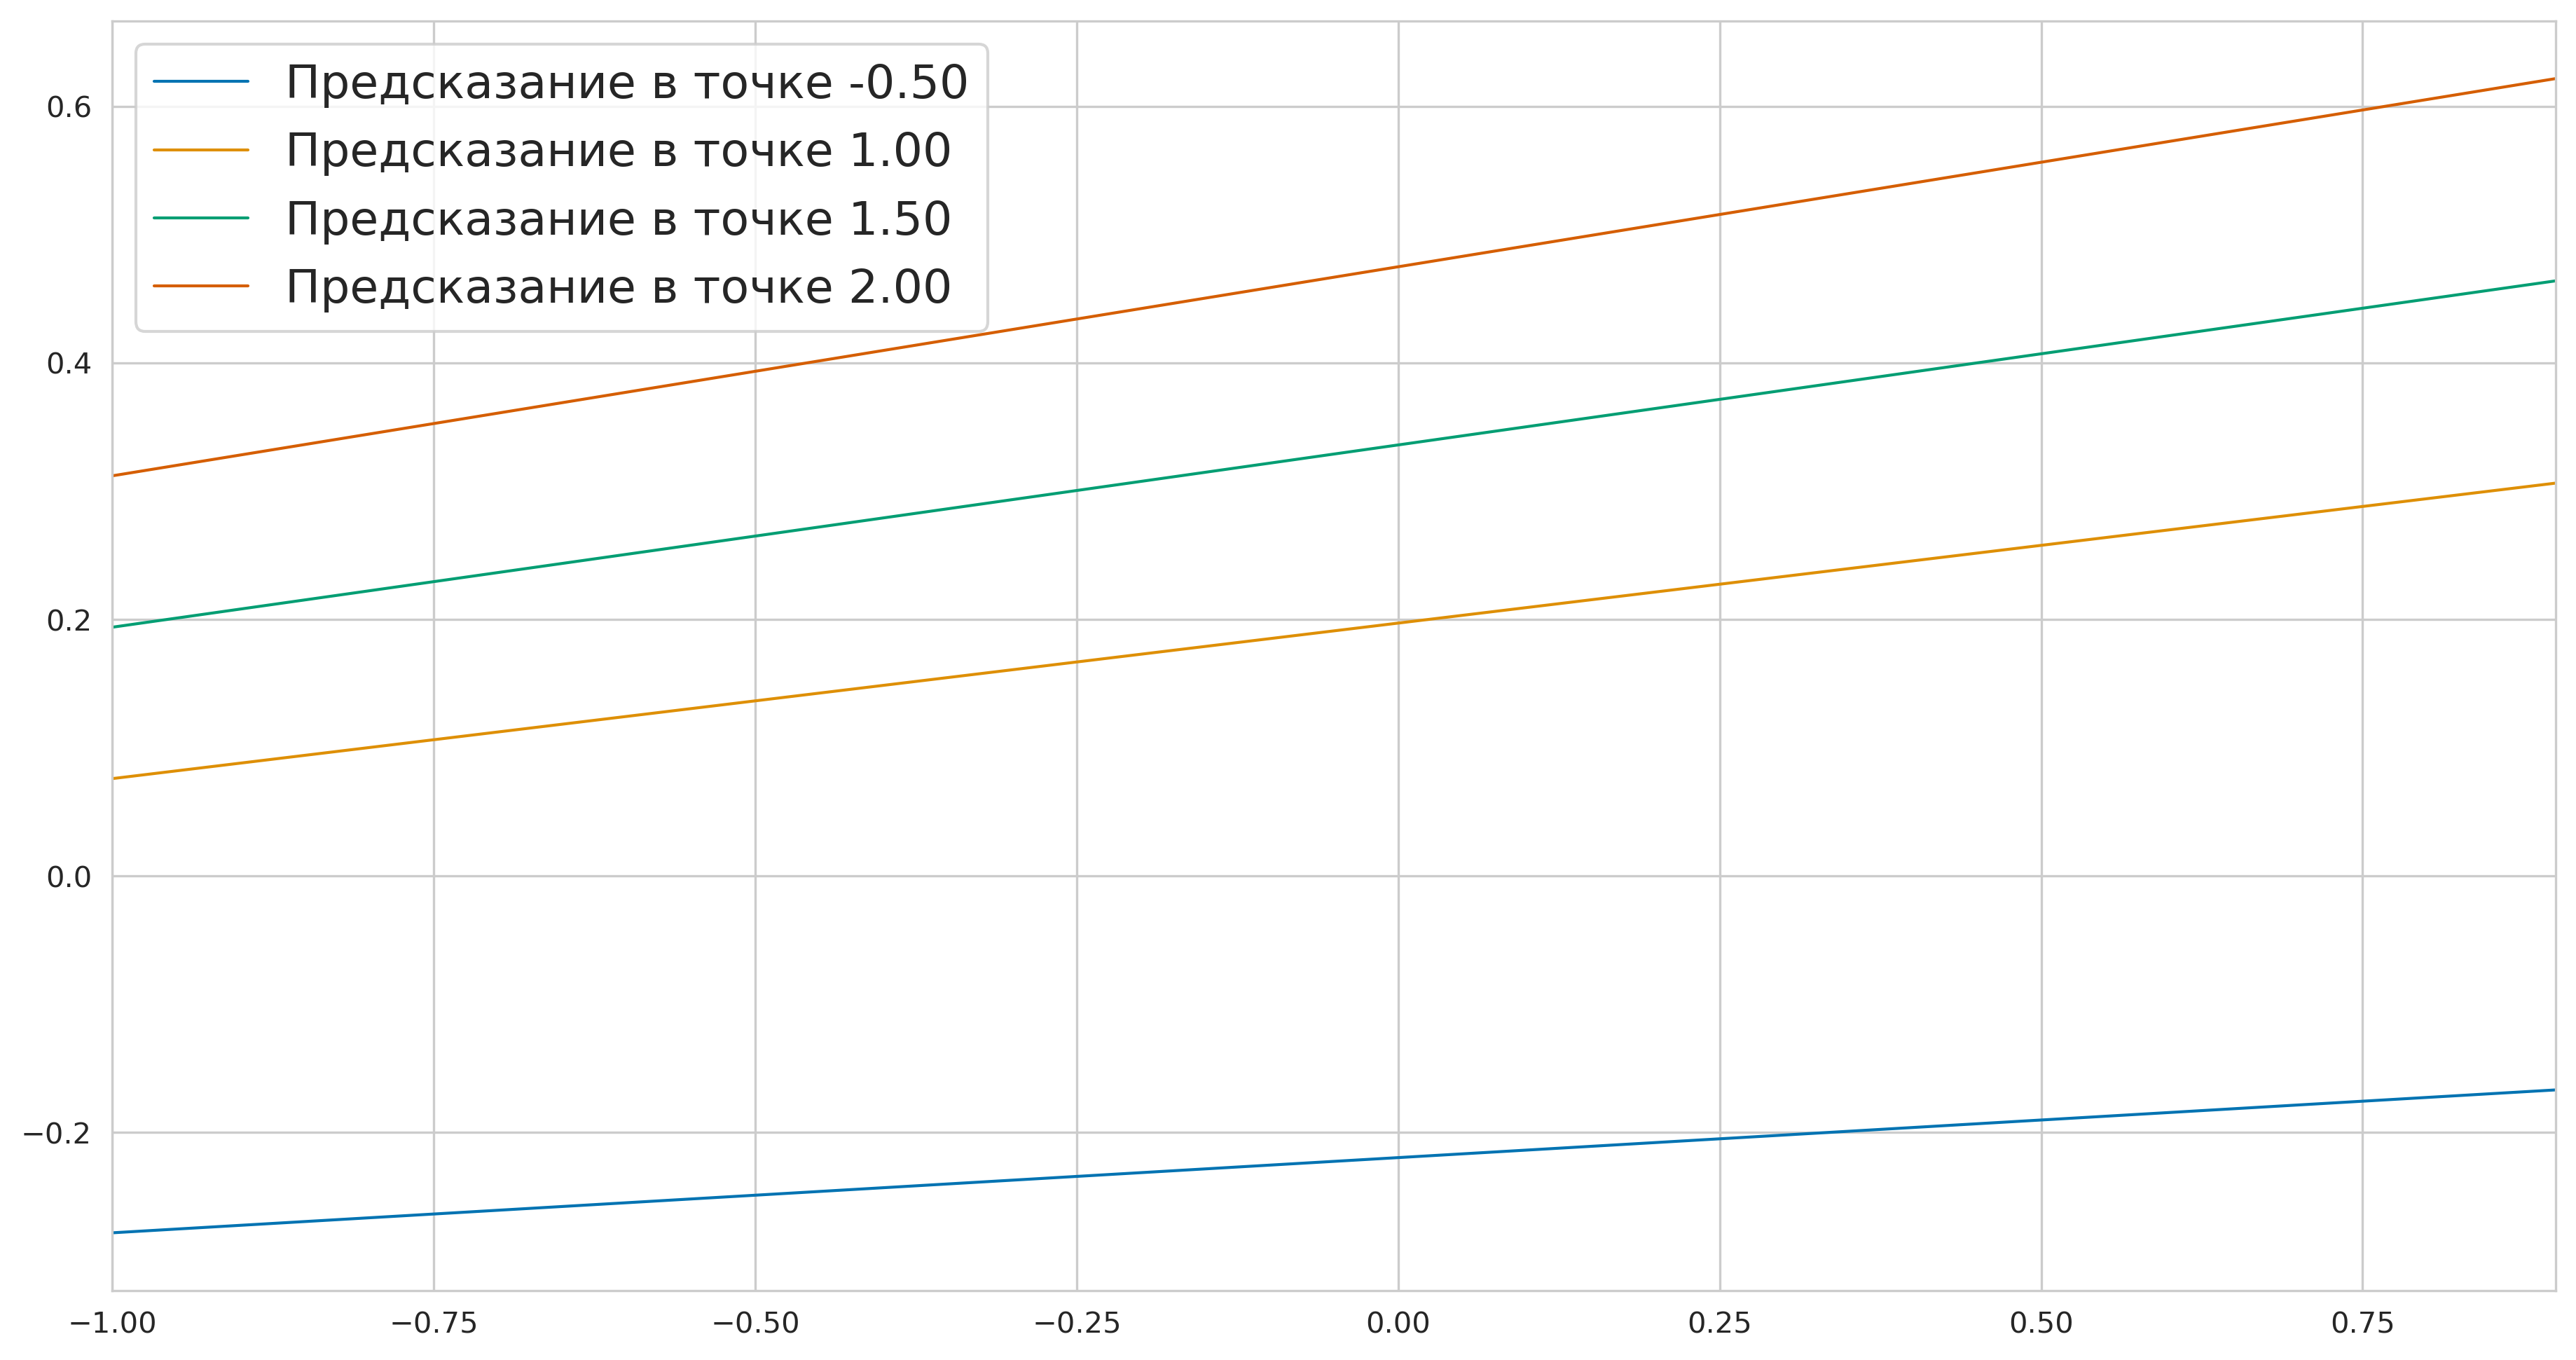

In [12]:
def get_one_prediction(x_pred, cur_y, d=1, data_ind=7, data=data):
    new_data = np.copy(data)
    new_data[data_ind] = cur_y
    cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], new_data )
    return cur_model.predict(np.array([x_pred]).reshape(1,-1))[0]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ys = np.arange(-1, 1, 0.1)
ax.set_xlim((ys[0], ys[-1]))

for x_pred in [-.5, 1, 1.5, 2]:
    one_pred = [ get_one_prediction(x_pred, y) for y in ys ]
    ax.plot(ys, one_pred, linewidth=1, label="Предсказание в точке %.2f" % x_pred)

ax.legend(fontsize=legend_fontsize)